### Mutual info score feature selection

In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import pandas as pd
df = pd.read_csv('train_titanic.csv')

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
s = df.isna().sum()
s[s>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

#### seperate x and y features

In [6]:
x = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Survived'])
y = df[['Survived']]

In [7]:
x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


In [8]:
y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


#### cat con seperation for x

In [9]:
cat = list(x.columns[x.dtypes=='object'])
con = list(x.columns[x.dtypes!='object'])

In [10]:
cat

['Sex', 'Embarked']

In [11]:
con

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

#### Create a pipeline for feature selection
1. Use Ordinal encoder for Cat features

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

In [13]:
num_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),    #median for integer values
                           ('scaler', StandardScaler())])

In [14]:
cat_pipe = Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                           ('ordinal', OrdinalEncoder())])

In [15]:
pre = ColumnTransformer([('num', num_pipe, con),
                         ('cat', cat_pipe, cat)]).set_output(transform='pandas')

In [16]:
x_pre = pre.fit_transform(x)
x_pre.head()

,num__Pclass,num__Age,num__SibSp,num__Parch,num__Fare,cat__Sex,cat__Embarked
0,0.827377,-0.565736,0.432793,-0.473674,-0.502445,1.0,2.0
1,-1.566107,0.663861,0.432793,-0.473674,0.786845,0.0,0.0
2,0.827377,-0.258337,-0.474545,-0.473674,-0.488854,0.0,2.0
3,-1.566107,0.433312,0.432793,-0.473674,0.420730,0.0,2.0
4,0.827377,0.433312,-0.474545,-0.473674,-0.486337,1.0,2.0


#### Perform feature selection with mutual information scores

In [17]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(x_pre, y)
mi

array([0.04149119, 0.01597547, 0.00765869, 0.01738083, 0.14553073,
       0.15106424, 0.03933026])

In [18]:
mi = pd.Series(mi)
mi

0    0.041491
1    0.015975
2    0.007659
3    0.017381
4    0.145531
5    0.151064
6    0.039330
dtype: float64

In [19]:
mi.index = x_pre.columns
mi

num__Pclass      0.041491
num__Age         0.015975
num__SibSp       0.007659
num__Parch       0.017381
num__Fare        0.145531
cat__Sex         0.151064
cat__Embarked    0.039330
dtype: float64

In [20]:
mi = mi.sort_values(ascending=False)
mi

cat__Sex         0.151064
num__Fare        0.145531
num__Pclass      0.041491
cat__Embarked    0.039330
num__Parch       0.017381
num__Age         0.015975
num__SibSp       0.007659
dtype: float64

<Axes: >

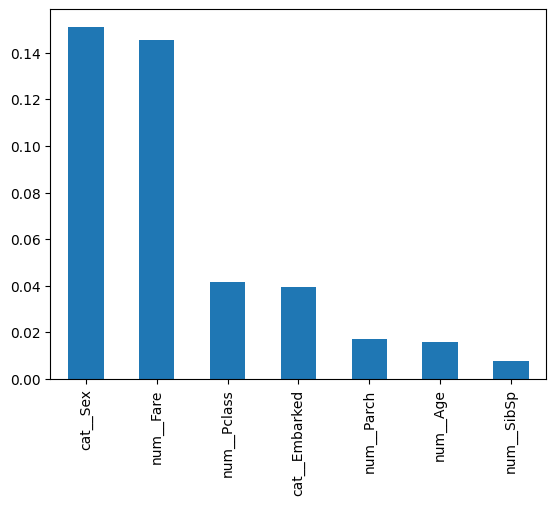

In [21]:
mi.plot(kind='bar')

#### select only top 5 features

In [22]:
from sklearn.feature_selection import SelectKBest
sel = SelectKBest(mutual_info_classif, k=5)
sel.fit(x_pre, y)
sel_cols = sel.get_feature_names_out()
sel_cols

array(['num__Pclass', 'num__Parch', 'num__Fare', 'cat__Sex',
       'cat__Embarked'], dtype=object)

#### get the original column names

In [23]:
sel_cols[0].split('__')

['num', 'Pclass']

In [24]:
sel_cols[0].split('__')[1]

'Pclass'

In [25]:
imp_cols = []  
for i in sel_cols:
    s = i.split('__')[1]
    imp_cols.append(s)


In [26]:
imp_cols

['Pclass', 'Parch', 'Fare', 'Sex', 'Embarked']

In [27]:
x_imp = x[imp_cols]
x_imp

,Pclass,Parch,Fare,Sex,Embarked
0,3,0,7.2500,male,S
1,1,0,71.2833,female,C
2,3,0,7.9250,female,S
3,1,0,53.1000,female,S
4,3,0,8.0500,male,S
...,...,...,...,...,...
886,2,0,13.0000,male,S
887,1,0,30.0000,female,S
888,3,2,23.4500,female,S
889,1,0,30.0000,male,C


#### seperate cat con for imp columns

In [28]:
cat_sel = list(x_imp.columns[x_imp.dtypes=='object'])
con_sel = list(x_imp.columns!='object')

In [29]:
cat_sel, con_sel

(['Sex', 'Embarked'], [True, True, True, True, True])

#### create a final preprocessing pipeline
1. now use onehot encoder

In [30]:
from sklearn.preprocessing import OneHotEncoder

In [31]:
num_pipe1 = Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())])

In [32]:
cat_pipe1 = Pipeline(steps=([('impute', SimpleImputer(strategy='most_frequent')),
                             ('OHE',OneHotEncoder(handle_unknown='ignore',sparse_output=False))]))

In [33]:
pre1 = ColumnTransformer([('num', num_pipe1, con_sel),
                          ('cat', cat_pipe, cat_sel)]).set_output(transform='pandas')

In [34]:
X_sel_pre = pre1.fit_transform(X_imp)
X_sel_pre.head()

NameError: name 'X_imp' is not defined